# SV model with variational particle filter

In [7]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
pd.set_option('precision',4)

import ptvi

In [8]:
data_seed, algo_seed = 1234, 1234
params = dict(a=1., b=0., c=.95)
T = 200

In [9]:
model = ptvi.FilteredStochasticVolatilityModelFreeProposal(
    input_length=T, num_particles=3000, resample=True)
model

Stochastic volatility model with parameters {a, b, c}:
	x_t = exp(a * z_t/2) ε_t        t=1,…,200
	z_t = b + c * z_{t-1} + ν_t,    t=2,…,200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Filter with 3000 particles; AR(1) proposal params {d, e, f}:
	z_t = d + e * z_{t-1} + f η_t,  t=2,…,200
	z_1 = d + f/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [10]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

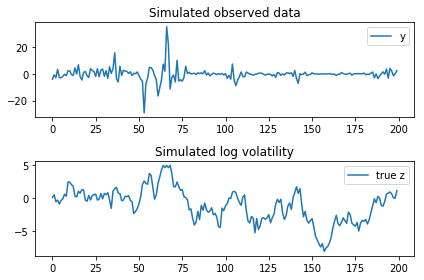

In [11]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [ ]:
torch.manual_seed(algo_seed)
trace = ptvi.PointEstimateTracer(model)
ζ0 = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
fit = ptvi.stoch_opt(
    model, y, opt_type=torch.optim.Adamax,
    tracer=trace, ζ0=ζ0,
    stop_heur=ptvi.NullStoppingHeuristic(), 
    max_iters=2**12)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Stochastic optimization for Particle filtered stochastic volatility model
  - Searching for point estimates only
  - Null stopping heuristic (never fires)
  - Adamax optimizer with param groups:
    group 0. lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed stochastic loss = -577.6
       1. smoothed stochastic loss = -577.4
       2. smoothed stochastic loss = -577.2
       4. smoothed stochastic loss = -576.6
       8. smoothed stochastic loss = -574.8
      16. smoothed stochastic loss = -570.3
      32. smoothed stochastic loss = -559.6
      64. smoothed stochastic loss = -539.9
     128. smoothed stochastic loss = -509.2


In [ ]:
trace.plot_objectives()

In [ ]:
trace.plot(figsize=[8,10])

In [ ]:
fit.summary(true=params)